# Sentiment Classification Using RNNs 

### In this example, we see sentiment classification.
### Intead of an Elman RNN built using the RNNCell, use built-in RNNs: nn.RNN, nn.LSTM, and nn.GRU.


In [1]:
from argparse import Namespace
import os
import json
from collections import Counter
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Vocabulary, Vectorizer, Dataset

In [2]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [4]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, review_vocab, rating_vocab, max_sequnce_length):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers; {'negative':0, 'positive':1}
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab
        self.max_sequnce_length = max_sequnce_length

    def vectorize(self, review, vector_length=-1):
        """
        Args:
            review (str): the string of words
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.review_vocab.begin_seq_index]       
                
        for token in review.split(" "):
            if token not in string.punctuation:
                indices.append(self.review_vocab.lookup_token(token))

        indices.append(self.review_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.review_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, review_df, cutoff=2):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = SequenceVocabulary()
        rating_vocab = Vocabulary()
        
        max_sequnce_length = 0
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        
        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            tokens = review.split(" ")
            if len(tokens) > max_sequnce_length:
                max_sequnce_length = len(tokens) 
            for word in tokens:
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab, max_sequnce_length)   

    @classmethod
    def from_serializable(cls, contents):
        review_vocab = SequenceVocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        return {'review_vocab': self.review_vocab.to_serializable(), 
                'rating_vocab': self.rating_vocab.to_serializable()}

In [5]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instatiated from dataset
        """
        self.review_df = review_df 
        self._vectorizer = vectorizer

        self._max_seq_length = self._vectorizer.max_sequnce_length + 2   # add 2 for begin_seq_token and end_seq_token

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = self.train_df.rating.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.rating_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        review_vector, vec_length = \
            self._vectorizer.vectorize(row.review, self._max_seq_length)
        
        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector, 
                'y_target': rating_index, 
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=False, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


## Model

In [6]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

def column_summation(y_out, x_lengths):
    '''Get a max or mean vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the max or mean vector of all the vectors by 
    the position indicated by the corresponding value in `x_lengths` at the row index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):      
        #out.append(y_out[batch_index, 0:column_index].mean(dim=0))  # get the mean vector
        out.append(y_out[batch_index, 0:column_index].max(dim=0).values)  # get the max vector

    return torch.stack(out)


class ElmanRNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)  # x_in[t]: (batch, feat_size); hidden_t: (batch, hidden_size)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens



class ReviewClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, bidirectional=False, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the word embeddings
            num_embeddings (int): The number of words to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of sentiment polarities
            bidirectional (bool): Informs whether bidrectional RNN is used
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(ReviewClassifier, self).__init__()

        if bidirectional == False:
             self.num_directions = 1
        else:
             self.num_directions = 2
        
        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        #self.rnn = ElmanRNN(input_size=embedding_size,
        #                     hidden_size=rnn_hidden_size,
        #                     batch_first=batch_first)

        #self.rnn = nn.RNN(input_size=embedding_size,
        self.rnn = nn.GRU(input_size=embedding_size,
        #self.rnn = nn.LSTM(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first, 
                             num_layers = 1,
                             dropout = 0.0, 
                             bidirectional=bidirectional)
        
        #self.fc1 = nn.Linear(in_features=rnn_hidden_size*self.num_directions,
        #                 out_features=rnn_hidden_size*self.num_directions)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size*self.num_directions,
                          out_features=num_classes)
        # for batch norm
        self.bn1 = nn.BatchNorm1d(rnn_hidden_size*self.num_directions) 


    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in) # x_embedded: (batch, seq_size, feat_size)
               
        # create PackedSequence; x_packed.data.shape=(number_items, embeddign_size)
        #x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(), batch_first=True)
        y_out, _ = self.rnn(x_embedded)        
        #y_out, _ = pad_packed_sequence(y_out, batch_first=True) # y_out: (batch, seq_size, hidden_size*num_directions)
        
        if x_lengths is not None:
             #y_out = column_gather(y_out, x_lengths)   # y_out gets the last hidden vector of each input: (batch, hidden_size*num_directions)
             y_out = column_summation(y_out, x_lengths) # y_out gets the max or mean hidden vector of each input
        else:
             y_out = y_out[:, -1, :]

        
        # with batch norm and dropout
        #y_out = F.relu(self.bn1(self.fc1(F.dropout(y_out, 0.5, training=self.training))))
        #y_out = F.relu(self.bn1(self.fc1(y_out)))

        
        # with dropout
        #y_out = self.fc2(F.dropout(y_out, 0.4, training=self.training))          # y_out: (batch, num_classes)
        y_out = self.fc2(y_out)

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

## Settings

In [8]:
args = Namespace(
    # Data and path information
    review_csv="data/rt-polaritydata/reviews_with_splits_lite.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/rt-polaritydata/review_classification",
    # Model hyper parameter
    word_embedding_size=200,
    rnn_hidden_size=200,
    bidirectional=False,
    #bidirectional=True,
    # Training hyper parameter
    num_epochs=100,
    #num_epochs=200,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: False


In [9]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv, 
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(embedding_size=args.word_embedding_size, 
                               num_embeddings=len(vectorizer.review_vocab),
                               num_classes=len(vectorizer.rating_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.review_vocab.mask_index,
                               bidirectional=args.bidirectional)

In [10]:
len(vectorizer.review_vocab)

5571

In [11]:
vectorizer.review_vocab._token_to_idx

{'<MASK>': 0,
 '<UNK>': 1,
 '<BEGIN>': 2,
 '<END>': 3,
 'this': 4,
 'plot': 5,
 'feels': 6,
 'especially': 7,
 'thin': 8,
 'stretched': 9,
 'over': 10,
 'the': 11,
 'nearly': 12,
 'minute': 13,
 'running': 14,
 'time': 15,
 'complete': 16,
 'lack': 17,
 'of': 18,
 'originality': 19,
 'cleverness': 20,
 'or': 21,
 'even': 22,
 'effort': 23,
 'there': 24,
 's': 25,
 'an': 26,
 'admirable': 27,
 'rigor': 28,
 'to': 29,
 'relentless': 30,
 'anger': 31,
 'and': 32,
 'script': 33,
 'refusal': 34,
 'a': 35,
 'happy': 36,
 'ending': 37,
 'but': 38,
 'as': 39,
 'those': 40,
 'on': 41,
 'you': 42,
 'realize': 43,
 'no': 44,
 'place': 45,
 'for': 46,
 'story': 47,
 'go': 48,
 'down': 49,
 'is': 50,
 'group': 51,
 'more': 52,
 'self': 53,
 'absorbed': 54,
 'women': 55,
 'than': 56,
 'mother': 57,
 'in': 58,
 'film': 59,
 'i': 60,
 'don': 61,
 't': 62,
 'think': 63,
 'so': 64,
 'nothing': 65,
 'wrong': 66,
 'with': 67,
 'performances': 68,
 'here': 69,
 'characters': 70,
 'me': 71,
 'not': 72,
 're

## Training Routine

In [12]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [13]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()
           
            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

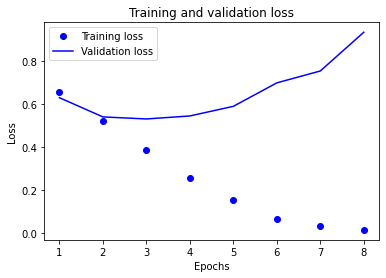

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

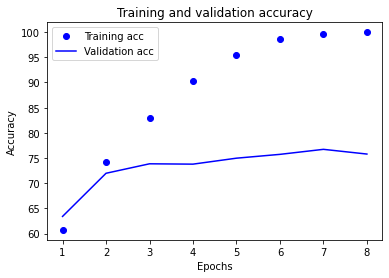

In [15]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_rating_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])

    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
    y_rating_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [17]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.5486391091346742;
Test Accuracy: 72.7842741935484


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
rating_classes = []
for i in range(len(dataset._vectorizer.rating_vocab)):
    rating_classes.append(dataset._vectorizer.rating_vocab.lookup_index(i))
print(rating_classes)

['negative', 'positive']


In [19]:
import pandas as pd
cm = confusion_matrix(y_rating_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=rating_classes, columns=rating_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       negative  positive
Predicted                    
negative        638       274
positive        161       525


In [20]:
print(classification_report(y_rating_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       799
           1       0.77      0.66      0.71       799

    accuracy                           0.73      1598
   macro avg       0.73      0.73      0.73      1598
weighted avg       0.73      0.73      0.73      1598



### Inference

In [21]:
def predict_sentiment(review, classifier, vectorizer):
    vectorized_review, vec_length = vectorizer.vectorize(review)
    vectorized_review = torch.tensor(vectorized_review).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_review, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_rating = vectorizer.rating_vocab.lookup_index(index)

    return {'sentiment': predicted_rating, 'probability': prob_value, 'review': review}

In [22]:
# review = input("Enter a review: ")
review = "i went here for restaurant week . the restaurant is not that nice inside the wait staff was not very professional . i ordered the chop salad . it appeared to be on leaf on lettuce chopped up no avocado as stated on menu blah . my steak was ordered medium came to table well done so it was sent back . the bread was not made fresh there tasted like a roll from fry s . dessert was okay . much better places out there for much cheaper . i won t be going back !"
classifier = classifier.to("cpu")
print(predict_sentiment(review, classifier, vectorizer))

{'sentiment': 'negative', 'probability': 0.7948821187019348, 'review': 'i went here for restaurant week . the restaurant is not that nice inside the wait staff was not very professional . i ordered the chop salad . it appeared to be on leaf on lettuce chopped up no avocado as stated on menu blah . my steak was ordered medium came to table well done so it was sent back . the bread was not made fresh there tasted like a roll from fry s . dessert was okay . much better places out there for much cheaper . i won t be going back !'}
